In [79]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


If the `econml` and `wget` python packages are not installed on your machine install them by running the cells below.

In [80]:
!pip install econml

Defaulting to user installation because normal site-packages is not writeable


In [81]:
!pip install wget

Defaulting to user installation because normal site-packages is not writeable


Importing all the necessary components

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.special
from sklearn.linear_model import LassoCV, LinearRegression, ElasticNetCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.base import clone
import joblib
from statsmodels.api import OLS
from sklearn.model_selection import StratifiedGroupKFold, GroupKFold, KFold, StratifiedKFold
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit

In [83]:
import wget
import os

if os.path.exists('datasets.py'):
    os.remove('datasets.py')
wget.download('https://raw.githubusercontent.com/CausalAIBook/MetricsMLNotebooks/main/T/datasets.py')

if os.path.exists('myxgb.py'):
    os.remove('myxgb.py')
wget.download('https://raw.githubusercontent.com/CausalAIBook/MetricsMLNotebooks/main/T/myxgb.py')

100% [................................................................................] 5006 / 5006

'myxgb.py'

# Setting the High Level Parameters for the Notebook

The 401k dataset is downloaded from the source by the code and no need to further download anything:
https://raw.githubusercontent.com/CausalAIBook/MetricsMLNotebooks/main/data/401k.csv

The welfare dataset is downloaded from the source by the code and no need to further download anything:
https://github.com/gsbDBI/ExperimentData/blob/master/Welfare/ProcessedData/welfarenolabel3.csv 

It is drawn from the analysis in this paper: [Green and Kern, 2012, Modeling Heterogeneous Treatment Effects in Survey Experiments with Bayesian Additive Regression Trees](https://github.com/gsbDBI/ExperimentData/blob/master/Welfare/Green%20and%20Kern%20BART.pdf)

In [84]:
dataset = '401k'

In [85]:
if dataset == '401k':
    verbose = 0 # verbosity of auto-ml
    n_splits = 5 # cross-fitting and cross-validation splits
    cfit = False
    data = '401k' # which dataset, one of {'401k', 'criteo', 'welfare', 'poverty', 'star'}
    plot = True # whether to plot results
    xfeat = 'inc' # feature to use as x axis in plotting, e.g. for criteo 'f1', for 401k 'inc', for welfare 'polviews'
    # Formula for the BLP of CATE regression.
    blp_formula = 'np.log(inc)' # e.g. 'f1' for criteo, np.log(inc)' for 401k, 'C(polviews)' for the welfare case.
    blp_formula_short = 'log(inc)'
    blp_formula2 = 'np.log(inc) + np.power(np.log(inc), 2) + np.power(np.log(inc), 3) + np.power(np.log(inc), 4)'
    blp_formula2_short = 'poly(log(inc), 4)'
    hetero_feats = 'all' # list of subset of features to be used for CATE model or the string 'all' for everything
    cov_clip = .01 # clipping of treatment variance p(x)*(1-p(x)), whenever used in inverse propensities
    binary_y = False
    random_seed = 1
    # treatment policy to evaluate
    policy = lambda x: x['inc'] > 30000
    # cost of treatment when performing optimal policy learning, can also be viewed as "threshold for treatment"
    treatment_cost = 4000

    ## For semi-synthetic data generation
    semi_synth = False # Whether true outcome y should be replaced by a fake outcome from a known CEF
    simple_synth = True # Whether the true CEF of the fake y should be simple or fitted from data
    max_depth = 2 # max depth of random forest during for semi-synthetic model fitting
    scale = .2 # magnitude of noise in semi-synthetic data
    def simple_true_cef(D, X): # simple CEF of the outcome for semi-synthetic data
        return .5 * np.array(X)[:, 1] * D + np.array(X)[:, 1]

In [86]:
if dataset == 'welfare':
    verbose = 0 # verbosity of auto-ml
    n_splits = 5 # cross-fitting and cross-validation splits
    cfit = True
    data = 'welfare' # which dataset, one of {'401k', 'criteo', 'welfare', 'poverty', 'star'}
    plot = True # whether to plot results
    xfeat = 'polviews' # feature to use as x axis in plotting, e.g. for criteo 'f1', for 401k 'inc', for welfare 'polviews'
    # Formula for the BLP of CATE regression.
    blp_formula = 'C(polviews)' # e.g. 'f1' for criteo, np.log(inc)' for 401k, 'C(polviews)' for the welfare case.
    blp_formula_short = 'C(polviews)'
    blp_formula2 = 'polviews'
    blp_formula2_short = 'polviews'
    hetero_feats = 'all' # list of subset of features to be used for CATE model or the string 'all' for everything
    cov_clip = .01 # clipping of treatment variance p(x)*(1-p(x)), whenever used in inverse propensities
    binary_y = True
    random_seed = 1
    # treatment policy to evaluate
    policy = lambda x: x['polviews'] > 3
    # cost of treatment when performing optimal policy learning, can also be viewed as "threshold for treatment"
    treatment_cost = -.3

    ## For semi-synthetic data generation
    semi_synth = False # Whether true outcome y should be replaced by a fake outcome from a known CEF
    simple_synth = True # Whether the true CEF of the fake y should be simple or fitted from data
    max_depth = 2 # max depth of random forest during for semi-synthetic model fitting
    scale = .2 # magnitude of noise in semi-synthetic data
    def simple_true_cef(D, X): # simple CEF of the outcome for semi-synthetic data
        return .5 * np.array(X)[:, 1] * D + np.array(X)[:, 1]

# Fetching and Constructing the Dataset

The data generator also allows for semi-synthetic data generation where the ground truth CATE is known, which can be used for evaluation of different methods.

In [87]:
from datasets import fetch_data_generator

get_data, abtest, true_cef, true_cate = fetch_data_generator(data=data, semi_synth=semi_synth,
                                                             simple_synth=simple_synth,
                                                             scale=scale, true_f=simple_true_cef,
                                                             max_depth=max_depth)
X, D, y, groups = get_data()

In [88]:
if semi_synth:
    true_ate = np.mean(true_cate(X))
    print(f'True ATE: {true_ate}')

In [89]:
def rmse(cate, preds):
    return np.sqrt(np.mean((cate - preds)**2))

# Data Analysis

We now have our data $X$, $D$, $y$, of controls, treatments and outcomes. In some datasets, we also have "groups", also known as "clusters". These are group ids, that define a group of samples that are believed to be correlated through unobesrved factors. For instance, in randomized experiments when a whole class is being treated and we have data at the student level, the students in a class constitute a cluster, as their outcome variables are most probably correlated. In such settings, it is helpful to account for the cluster correlations when calculating confidence intervals and when performing sample splitting for either cross-validation or for nuisance estimation.

We will be assuming throughout that conditional ignorability is satisfied if we control for all the variables $X$, i.e. the potential outcomes $Y(1), Y(0)$ satisfy
\begin{align}
Y(1), Y(0) ~\perp\hspace{-1em}\perp~D \mid X
\end{align}
Equivalently, we assume that the DAG the corresponds to our setting satisfies that $X$ is a valid adjustment set between $D$ and $Y$, i.e. it blocks all backdoor paths in the DAG.

In [90]:
X.describe()

,age,inc,fsize,educ,db,marr,male,twoearn,pira,nohs,hs,smcol,col,hown
count,9716.000000,9716.000000,9716.000000,9716.000000,9716.000000,9716.000000,9716.000000,9716.000000,9716.000000,9716.000000,9716.000000,9716.000000,9716.000000,9716.000000
mean,41.034891,36462.224269,2.868361,13.192672,0.271202,0.603746,0.205949,0.380198,0.238678,0.127419,0.379477,0.247118,0.245986,0.635241
std,10.337014,22193.821846,1.541154,2.787505,0.444603,0.489143,0.404414,0.485460,0.426298,0.333459,0.485282,0.431358,0.430692,0.481387
min,25.000000,4080.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32.000000,19648.500000,2.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,40.000000,31473.000000,3.000000,12.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,48.000000,48071.250000,4.000000,15.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,64.000000,118599.000000,13.000000,18.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


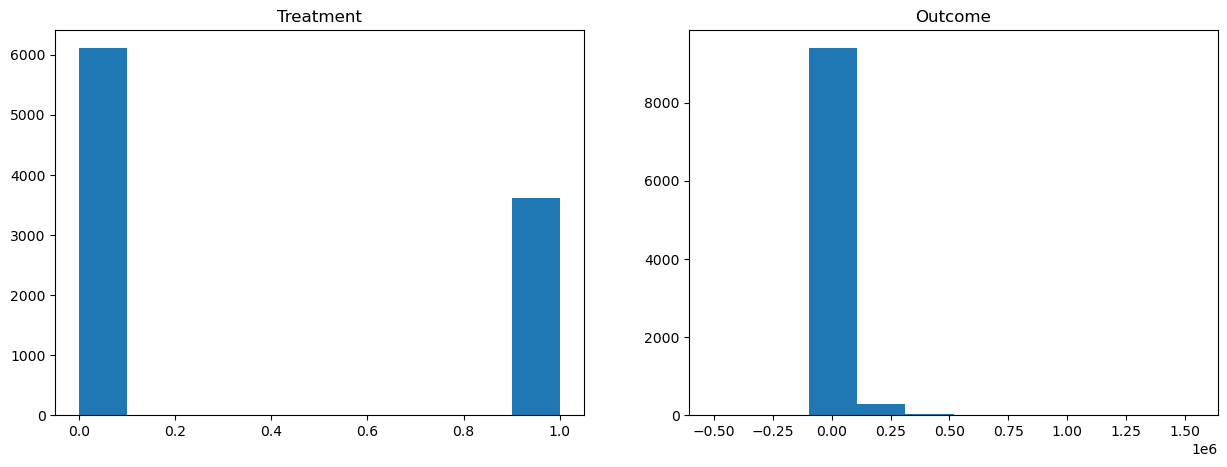

In [91]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(D)
plt.title('Treatment')
plt.subplot(1, 2, 2)
plt.hist(y)
plt.title('Outcome')
plt.show()

In [92]:
# simple two means estimate which would be wrong unless an randomized trial
OLS(y, np.hstack([np.ones((D.shape[0], 1)), D.reshape(-1, 1)])).fit(cov_type='HC1').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     211.2
Date:                Wed, 14 Feb 2024   Prob (F-statistic):           2.35e-47
Time:                        13:05:56   Log-Likelihood:            -1.1960e+05
No. Observations:                9716   AIC:                         2.392e+05
Df Residuals:                    9714   BIC:                         2.392e+05
Df Model:                           1                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9925.5573    596.973     16.626      0.000    8755.511    1.11e+04
x1          1.769e+04   1217.458     14.533      0.000    1.53e+04    2.01e+04
==============================================================================
Omnibus:                    15808.021   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         17742973.002
Skew:                          10.566   Prob(JB):                         0.00
Kurtosis:                     211.282   Cond. No.                         2.43
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

# Nuisance Cross-Fitted Estimation and Prediction

We will estimate regression models for each of the nuisance functions that arise in CATE learning approaches. The five models correspond to the following five predictive problems:
\begin{align}
\text{model_y} ~\rightarrow~& q(x) := E[Y\mid X=x]\\
\text{model_t} ~\rightarrow~& p(x) := E[D\mid X=x] = \Pr(D=1\mid X=x)\\
\text{model_reg_zero} ~\rightarrow~& g_0(x) := E[Y\mid D=0, X=x]\\
\text{model_reg_one} ~\rightarrow~& g_1(x) := E[Y\mid D=1, X=x]\\
\end{align}
We will use gradient boosting regression with early stopping for each of these models.

For each of the nuisance models we perform cross-fitting to get out-of-fold predictions from each of these nuisance models. At the end of this process, we will have for each sample $i$, the following out-of-fold nuisance values:
\begin{align}
\text{reg_preds_t} \rightarrow~& \hat{g}_0(X_i) (1 - D_i) + \hat{g}_1(X_i) D_i &
\text{reg_one_preds_t} \rightarrow~& \hat{g}_1(X_i) &
\text{reg_zero_preds_t} \rightarrow~& \hat{g}_0(X_i)\\
\text{res_preds} \rightarrow~& \hat{q}(X_i) &
\text{prop_preds} \rightarrow~& \hat{p}(X_i)
\end{align}

In [93]:
from myxgb import xgb_reg, xgb_clf

auto_reg = lambda: xgb_reg(random_seed)
auto_clf = lambda: xgb_clf(random_seed)

In [94]:
if cfit:
    if groups is None:
        cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
        splits = list(cv.split(X, D))
    else:
        cv = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
        splits = list(cv.split(X, D, groups=groups))
else:
    splits = [(np.arange(X.shape[0]), np.arange(X.shape[0]))]

n = X.shape[0]
reg_preds_t = np.zeros(n)
reg_zero_preds_t = np.zeros(n)
reg_one_preds_t = np.zeros(n)

for train, test in splits:
    reg_zero = auto_reg().fit(X.iloc[train][D[train]==0], y[train][D[train]==0])
    reg_one = auto_reg().fit(X.iloc[train][D[train]==1], y[train][D[train]==1])
    reg_zero_preds_t[test] = reg_zero.predict(X.iloc[test])
    reg_one_preds_t[test] = reg_one.predict(X.iloc[test])
    reg_preds_t[test] = reg_zero_preds_t[test] * (1 - D[test]) + reg_one_preds_t[test] * D[test]

res_preds = cross_val_predict(auto_reg(), X, y, cv=splits)
prop_preds = cross_val_predict(auto_clf(), X, D, cv=splits)

# Evaluating Nuisance Model Performance

We now also evaluate the performance of the selected models in terms of R^2

In [95]:
def r2score(y, ypred):
    return 1 - np.mean((y - ypred)**2) / np.var(y)

In [96]:
print(f"R^2 of model for (y ~ X): {r2score(y, res_preds):.4f}")
print(f"R^2 of model for (D ~ X): {r2score(D, prop_preds):.4f}")
print(f"R^2 of model for (y ~ X | D==0): {r2score(y[D==0], reg_zero_preds_t[D==0]):.4f}")
print(f"R^2 of model for (y ~ X | D==1): {r2score(y[D==1], reg_one_preds_t[D==1]):.4f}")
print(f"R^2 of model for (y ~ D, X): {r2score(y, reg_preds_t):.4f}")

R^2 of model for (y ~ X): 0.2501
R^2 of model for (D ~ X): 0.1670
R^2 of model for (y ~ X | D==0): 0.1947
R^2 of model for (y ~ X | D==1): 0.2483
R^2 of model for (y ~ D, X): 0.2421


# Doubly-Robust ATE Estimation

Using the doubly robust method. In particular, we construct the doubly robust variables
\begin{align}
Y_i^{DR}(\hat{g},\hat{p}) := \hat{g}_1(X_i) - \hat{g}_0(X_i) + (Y_i - \hat{g}_{D_i}(X_i))\frac{D_i - \hat{p}(X_i)}{\hat{p}(X_i) (1-\hat{p}(X_i))}
\end{align}
and then we estimate:
\begin{align}
ATE = E_n\left[Y^{DR}(\hat{g},\hat{p})\right]
\end{align}
This should be more efficient in the worst-case and should be returning a consistent estimate of the ATE even beyond RCTs and will also correctly account for any imbalances or violations of the randomization assumption in an RCT.

In [98]:
dr_preds = reg_one_preds_t - reg_zero_preds_t
dr_preds += (y - reg_preds_t) * (D - prop_preds) / np.clip(prop_preds * (1 - prop_preds), cov_clip, np.inf)

if groups is None:
    display(OLS(dr_preds, np.ones((len(dr_preds), 1))).fit(cov_type='HC1').summary())
else:
    display(OLS(dr_preds, np.ones((len(dr_preds), 1))).fit(cov_type='cluster', cov_kwds={'groups': groups}).summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 14 Feb 2024   Prob (F-statistic):                nan
Time:                        13:06:27   Log-Likelihood:            -1.2531e+05
No. Observations:                9716   AIC:                         2.506e+05
Df Residuals:                    9715   BIC:                         2.506e+05
Df Model:                           0                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7804.8706    979.838      7.965      0.000    5884.424    9725.318
==============================================================================
Omnibus:                     7532.548   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         31520906.701
Skew:                          -2.089   Prob(JB):                         0.00
Kurtosis:                     282.005   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

# Best Linear CATE Predictor

We can also use the doubly robust variables as pseudo-outcomes in an OLS regression, so as to estimate the best linear approximation of the true CATE. In an RCT, these should be similar to the coefficients recovered in a plain interactive OLS regression.

In [ ]:
dfX = X.copy()
dfX['const'] = 1
if groups is None:
    lr = OLS(dr_preds, dfX).fit(cov_type='HC1')
    cov = lr.get_robustcov_results(cov_type='HC1')
else:
    lr = OLS(dr_preds, dfX).fit(cov_type='cluster', cov_kwds={'groups': groups})
    cov = lr.get_robustcov_results(cov_type='cluster', groups=groups)
lr.summary()

# Simultaneous (Joint) Confidence Intervals
We can also perform joint inference on all these parameters controlling the joint probability of failure of the confidence intervals by 95%.

In [ ]:
V = cov.cov_params()
S = np.diag(np.diagonal(V)**(-1/2))
epsilon = np.random.multivariate_normal(np.zeros(V.shape[0]), S @ V @ S, size=(1000))
critical = np.percentile(np.max(np.abs(epsilon), axis=1), 95)
stderr = np.diagonal(V)**(1/2)
lb = cov.params - critical * stderr
ub = cov.params + critical * stderr
jointsummary = pd.DataFrame({'coef': cov.params,
                             'std err': stderr,
                             'lb': lb,
                             'ub': ub,
                             'statsig': ['' if ((l <= 0) & (0 <= u)) else '**' for (l, u) in zip(lb, ub)]},
                            index=dfX.columns)
display(jointsummary)

# Confidence Intervals on BLP of CATE Predictions

We can also produce confidence intervals for the predictions of the CATE at particular points

In [ ]:
grid = np.unique(np.percentile(dfX[xfeat], np.arange(0, 110, 20)))

Zpd = pd.DataFrame(np.tile(np.median(dfX, axis=0, keepdims=True), (len(grid), 1)),
                    columns=dfX.columns)
Zpd[xfeat] = grid

pred_df = lr.get_prediction(Zpd).summary_frame()
preds, lb, ub = pred_df['mean'].values, pred_df['mean_ci_lower'].values, pred_df['mean_ci_upper'].values
preds = preds.flatten()
lb = lb.flatten()
ub = ub.flatten()
plt.errorbar(Zpd[xfeat], preds, yerr=(preds-lb, ub-preds))
plt.xlabel(xfeat)
plt.ylabel('Predicted CATE (at median value of other features)')
plt.show()

# Simultaneous (Joint) Confidence Intervals on BLP of CATE Predictions

And even simultaneous inference on all these predictions that controls the joint failure probability of these confidence intervals to be at most 95%

In [ ]:
predsV = Zpd.values @ V @ Zpd.values.T
predsS = np.diag(np.diagonal(predsV)**(-1/2))
epsilon = np.random.multivariate_normal(np.zeros(predsV.shape[0]), predsS @ predsV @ predsS, size=(1000))
critical = np.percentile(np.max(np.abs(epsilon), axis=1), 95)
stderr = np.diagonal(predsV)**(1/2)
lb = preds - critical * stderr
ub = preds + critical * stderr

plt.errorbar(Zpd[xfeat], preds, yerr=(preds-lb, ub-preds))
plt.xlabel(xfeat)
plt.ylabel('Predicted CATE (at median value of other features)')
plt.show()

# Simpler Best Linear Projections of CATE

In [ ]:
from statsmodels.formula.api import ols
df = X.copy()
df['dr'] = dr_preds
if groups is None:
    lr = ols('dr ~ ' + blp_formula, df).fit(cov_type='HC1')
else:
    lr = ols('dr ~ ' + blp_formula, df).fit(cov_type='cluster', cov_kwds={'groups': groups})
lr.summary()

In [ ]:
grid = np.unique(np.percentile(X[xfeat], np.arange(0, 102, 2)))
Xpd = pd.DataFrame(np.tile(np.median(X, axis=0, keepdims=True), (len(grid), 1)),
                    columns=X.columns)
Xpd[xfeat] = grid
pred_df = lr.get_prediction(Xpd).summary_frame(alpha=.1)

In [ ]:
plt.plot(Xpd[xfeat], pred_df['mean'])
plt.fill_between(Xpd[xfeat], pred_df['mean_ci_lower'], pred_df['mean_ci_upper'], alpha=.4)
plt.xlabel(xfeat + ' (other features fixed at median value)')
plt.title('Predicted CATE BLP: cate ~' + blp_formula)
plt.ylabel('CATE')
plt.show()

In [ ]:
from statsmodels.formula.api import ols
df = X.copy()
df['dr'] = dr_preds
if groups is None:
    lr = ols('dr ~ ' + blp_formula2, df).fit(cov_type='HC1')
else:
    lr = ols('dr ~ ' + blp_formula2, df).fit(cov_type='cluster', cov_kwds={'groups': groups})

In [ ]:
grid = np.unique(np.percentile(X[xfeat], np.arange(0, 102, 2)))
Xpd = pd.DataFrame(np.tile(np.median(X, axis=0, keepdims=True), (len(grid), 1)),
                    columns=X.columns)
Xpd[xfeat] = grid
pred_df2 = lr.get_prediction(Xpd).summary_frame(alpha=.1)

In [ ]:
plt.plot(Xpd[xfeat], pred_df2['mean'])
plt.fill_between(Xpd[xfeat], pred_df2['mean_ci_lower'], pred_df2['mean_ci_upper'], alpha=.4)
plt.xlabel(xfeat + ' (other features fixed at median value)')
plt.ylabel('CATE')
plt.title('cate ~' + blp_formula2)
plt.show()

# Non-Parametric Confidence Intervals on CATE Predictions

We now move on to the subject of constructing confidence intervals for the predictions of CATE models. Confidence intervals for CATE predictions is an inherently harder task. In its generality it is at least as hard as constructing confidence intervals for the predictions of a non-parametric regression function; which is a statistically daunting task. 

We will use data-adaptive approaches like random forests to side step the curse of dimensionality and potentially adapt to sparsity in the regression function (though theoretically such an adaptivity is in the worst case imposssible; it tends to work well in practice). This is the approach taken by CausalForests or Doubly Robust Forests that are both based on the idea of Generalized Random Forests, which is an extension of classical forests for solving problems defined via conditional moment restrictions.

# Non-Parametric Confidence Intervals with Causal Forests

(standard errors here ignore cluster/group correlations if groups are not `None`)

In [ ]:
if hetero_feats == 'all':
    hetero_feats = X.columns

In [ ]:
Z = X[hetero_feats]

In [ ]:
if Z.shape[0] > 1e6:
    min_samples_leaf = 500
    max_samples = 0.05
else:
    min_samples_leaf = 50
    max_samples = .4

In [ ]:
from econml.grf import CausalForest

yres = y - res_preds
Dres = D - prop_preds
cf = CausalForest(4000, criterion='het', max_depth=None,
                  max_samples=max_samples,
                  min_samples_leaf=min_samples_leaf,
                  min_weight_fraction_leaf=.0,
                  random_state=random_seed)
cf.fit(Z, Dres, yres)

In [ ]:
top_feat = np.argsort(cf.feature_importances_)[-1]
print(Z.columns[top_feat])

In [ ]:
grid = np.unique(np.percentile(Z.iloc[:, top_feat], np.arange(0, 105, 5)))
Zpd = pd.DataFrame(np.tile(np.median(Z, axis=0, keepdims=True), (len(grid), 1)),
                    columns=Z.columns)
Zpd.iloc[:, top_feat] = grid

preds, lb, ub = cf.predict(Zpd, interval=True, alpha=.1)
preds = preds.flatten()
lb = lb.flatten()
ub = ub.flatten()
plt.errorbar(Zpd.iloc[:, top_feat], preds, yerr=(preds-lb, ub-preds))
plt.xlabel(Zpd.columns[top_feat])
plt.ylabel('Predicted CATE (at median value of other features)')
plt.savefig(f'{data}-causal-forest.png', dpi=600)
plt.show()

In [ ]:
if semi_synth:
    true_proj = true_cate(X)
    preds, lb, ub = cf.predict(Z, interval=True, alpha=.1)
    preds = preds.flatten()
    lb = lb.flatten()
    ub = ub.flatten()
    inds = np.argsort(true_proj)
    plt.plot(true_proj[inds], preds[inds])
    plt.fill_between(true_proj[inds], lb[inds].flatten(), ub[inds].flatten(), alpha=.4)
    plt.plot(np.linspace(np.min(true_proj), np.max(true_proj), 100),
             np.linspace(np.min(true_proj), np.max(true_proj), 100))
    plt.xlabel('True CATE')
    plt.ylabel('Predicted CATE')
    plt.show()

In [ ]:
important_feats = Z.columns[np.argsort(cf.feature_importances_)[::-1]]
important_feats[:4]

In [ ]:
plt.figure(figsize=(10, 7))
for it, feature in enumerate(important_feats[:4]):
    plt.subplot(2, 2, it + 1)
    grid = np.unique(np.percentile(Z[feature], np.arange(0, 105, 5)))
    Zpd = pd.DataFrame(np.tile(np.median(Z, axis=0, keepdims=True), (len(grid), 1)),
                        columns=Z.columns)
    Zpd[feature] = grid

    preds, lb, ub = cf.predict(Zpd, interval=True, alpha=.1)
    preds = preds.flatten()
    lb = lb.flatten()
    ub = ub.flatten()
    plt.errorbar(Zpd[feature], preds, yerr=(preds-lb, ub-preds))
    plt.xlabel(feature)
    plt.ylabel('Predicted CATE')
plt.tight_layout()
plt.savefig(f'{data}-cf-marginal-plots.png', dpi=600)
plt.show()

# Non-Parametric Confidence Intervals with Doubly Robust Forests

(standard errors here ignore cluster/group correlations)

In [ ]:
from econml.grf import RegressionForest

drrf = RegressionForest(4000, max_depth=5,
                        max_samples=max_samples,
                        min_samples_leaf=min_samples_leaf,
                        min_weight_fraction_leaf=.0,
                        random_state=random_seed)
drrf.fit(Z, dr_preds)

In [ ]:
top_feat = np.argsort(drrf.feature_importances_)[-1]
print(Z.columns[top_feat])

In [ ]:
grid = np.unique(np.percentile(Z.iloc[:, top_feat], np.arange(0, 105, 5)))
Zpd = pd.DataFrame(np.tile(np.median(Z.values, axis=0, keepdims=True), (len(grid), 1)),
                    columns=Z.columns)
Zpd.iloc[:, top_feat] = grid

preds, lb, ub = drrf.predict(Zpd, interval=True, alpha=.1)
preds = preds.flatten()
lb = lb.flatten()
ub = ub.flatten()
plt.errorbar(Zpd.iloc[:, top_feat], preds, yerr=(preds-lb, ub-preds))
plt.xlabel(Zpd.columns[top_feat])
plt.ylabel('Predicted CATE (at median value of other features)')
plt.savefig(f'{data}-doubly-robust-forest.png', dpi=600)
plt.show()

In [ ]:
important_feats = Z.columns[np.argsort(drrf.feature_importances_)[::-1]]
important_feats[:4]

In [ ]:
plt.figure(figsize=(10, 7))
for it, feature in enumerate(important_feats[:4]):
    plt.subplot(2, 2, it + 1)
    grid = np.unique(np.percentile(Z[feature], np.arange(0, 105, 5)))
    Zpd = pd.DataFrame(np.tile(np.median(Z, axis=0, keepdims=True), (len(grid), 1)),
                        columns=Z.columns)
    Zpd[feature] = grid

    preds, lb, ub = drrf.predict(Zpd, interval=True, alpha=.1)
    preds = preds.flatten()
    lb = lb.flatten()
    ub = ub.flatten()
    plt.errorbar(Zpd[feature], preds, yerr=(preds-lb, ub-preds))
    plt.xlabel(feature)
    plt.ylabel('Predicted CATE')
plt.tight_layout()
plt.savefig(f'{data}-drrf-marginal-plots.png', dpi=600)
plt.show()

In [ ]:
if semi_synth:
    true_proj = true_cate(X)
    preds, lb, ub = drrf.predict(Z, interval=True, alpha=.1)
    preds = preds.flatten()
    lb = lb.flatten()
    ub = ub.flatten()
    inds = np.argsort(true_proj)
    plt.plot(true_proj[inds], preds[inds])
    plt.fill_between(true_proj[inds], lb[inds].flatten(), ub[inds].flatten(), alpha=.4)
    plt.plot(np.linspace(np.min(true_proj), np.max(true_proj), 100),
             np.linspace(np.min(true_proj), np.max(true_proj), 100))
    plt.xlabel('True CATE')
    plt.ylabel('Predicted CATE')
    plt.show()

# Policy Evaluation

Suppose our goal is to estimate the best treatment policy $\pi: Z \to \{0, 1\}$. The policy gains over no treatment for any policy $\pi$ can be identified as:
\begin{align}
V(\pi) := E[\pi(Z)\, (Y(1) - Y(0))] = E\left[\pi(Z)\, Y^{DR}(g,p)\right]
\end{align}

#### Evaluating some personalized policy

In [ ]:
pi = (dr_preds - treatment_cost) * policy(Z)
point = np.mean(pi)
stderr = np.sqrt(np.var(pi) / pi.shape[0])
print(f"{point:.5f}, {stderr:.5f}, {point - 1.96 * stderr:.5f}, {point + 1.96 * stderr:.5f}")

#### As compared to treating everyone

In [ ]:
pi = (dr_preds - treatment_cost)
point = np.mean(pi)
stderr = np.sqrt(np.var(pi) / pi.shape[0])
print(f"{point:.5f}, {stderr:.5f}, {point - 1.96 * stderr:.5f}, {point + 1.96 * stderr:.5f}")